## Задача

- Найти датасет с каггла на классификацию тестов, согласовать со мной
- Решать задачу по тому же алгоритму, что и для Classic ML, использовать те же шаблоны
- Сделать детальный анализ текста на этапе EDA
- Добавить этапы препроцессинга для текстов: токенизация, удаление пунктуации и стоп-слов
- Извлечь важные фичи из текста. Использовать count-based методы в качестве бейслайна: CountVectorizer, TFIDFVectorizer, HashingVectorizer, предварительно сделав feature engineering. Поверх них использовать Classic ML модели для классификации
- Выполнить классификацию с использованием нейросетей, использовать Tensorflow keras. Попробовать RNN, LSTM
- Сделать то же самое с использованием Pytorch (для практики)
- Попробовать использовать готовые эмбеддинги для токенов и инициализировать ими embedding слой. Посмотреть, улучшился ли результат
- Попробовать использовать предобученные модели (transformers, BERT, …). Смотреть варианты на huggingface
- Попробовать генерировать эмбеддинги для теста целиком, используя предобученные модели (в качестве этапа препроцессинга), а поверх использовать Classic ML модели. Можно так же попробовать эмбеддинги от OpenAI или любых других LLM

In [1]:
# Автоматическая перезагрузка модулей при изменении
# Это позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2

In [2]:
! pip install numpy pandas scikit-learn catboost matplotlib seaborn phik nltk wordcloud imblearn tensorflow tiktoken

## Описание

https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

Title: title of news article

Text: body text of news article

Subject: subject of news article

Date: publish date of news article

target: target(0, 1)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from helper import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
from plots import *
from nlp import *

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nemow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv('dataset.csv', index_col=0)

In [6]:
df.head(100)

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
95,Roy Moore Supporting Republican LOSES It Afte...,If the scandal around the stories of Alabama S...,News,"November 14, 2017",0
96,That Story Trump Just Told The Press About Ob...,"On Tuesday, Donald Trump told a story about Ai...",News,"November 14, 2017",0
97,This 4-Year Old Tweet From Donald Trump Shows...,After Hollywood producer Harvey Weinstein was ...,News,"November 13, 2017",0
98,OOPS: Trump Judicial Nominee Didn’t Tell Cong...,This is a major conflict of interest that shou...,News,"November 13, 2017",0


0 - false, 1 - true

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [8]:
df['subject'].value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

нужно прикрутить кодирование

In [9]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

Пропусков нет

In [10]:
df.duplicated().sum()

np.int64(209)

дубликатов не так уж и много

In [11]:
df = df.drop_duplicates()

df.duplicated().sum()

np.int64(0)

In [12]:
df['target'].value_counts()

target
0    23478
1    21211
Name: count, dtype: int64

In [13]:
import re

def preprocessing(text):
    text = text.lower() # удалим все знаки препинания, ссылки и тд, а так же сделаем все слова с маленькой буквы
    
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', text)
    text = re.sub(r'<.*?>', '', text)
    
    return text

In [14]:
cols_to_clean = ["title", "text"]

for col in cols_to_clean:
    df[col] = df[col].apply(preprocessing)

In [15]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(df)

# df = tokenizer.texts_to_sequences(df)

In [16]:
df

,title,text,subject,date,target
0,donald trump sends out embarrassing new year ...,donald trump just couldn t wish all americans ...,News,"December 31, 2017",0
1,drunk bragging trump staffer started russian ...,house intelligence committee chairman devin nu...,News,"December 31, 2017",0
2,sheriff david clarke becomes an internet joke...,on friday it was revealed that former milwauke...,News,"December 30, 2017",0
3,trump is so obsessed he even has obama s name...,on christmas day donald trump announced that h...,News,"December 29, 2017",0
4,pope francis just called out donald trump dur...,pope francis used his annual christmas day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
44893,fully committed nato backs new u s approach o...,brussels reuters nato allies on tuesday welcom...,worldnews,"August 22, 2017",1
44894,lexisnexis withdrew two products from chinese ...,london reuters lexisnexis a provider of legal ...,worldnews,"August 22, 2017",1
44895,minsk cultural hub becomes haven from authorities,minsk reuters in the shadow of disused soviet ...,worldnews,"August 22, 2017",1
44896,vatican upbeat on possibility of pope francis ...,moscow reuters vatican secretary of state card...,worldnews,"August 22, 2017",1


датасет сбалансирован

## EDA

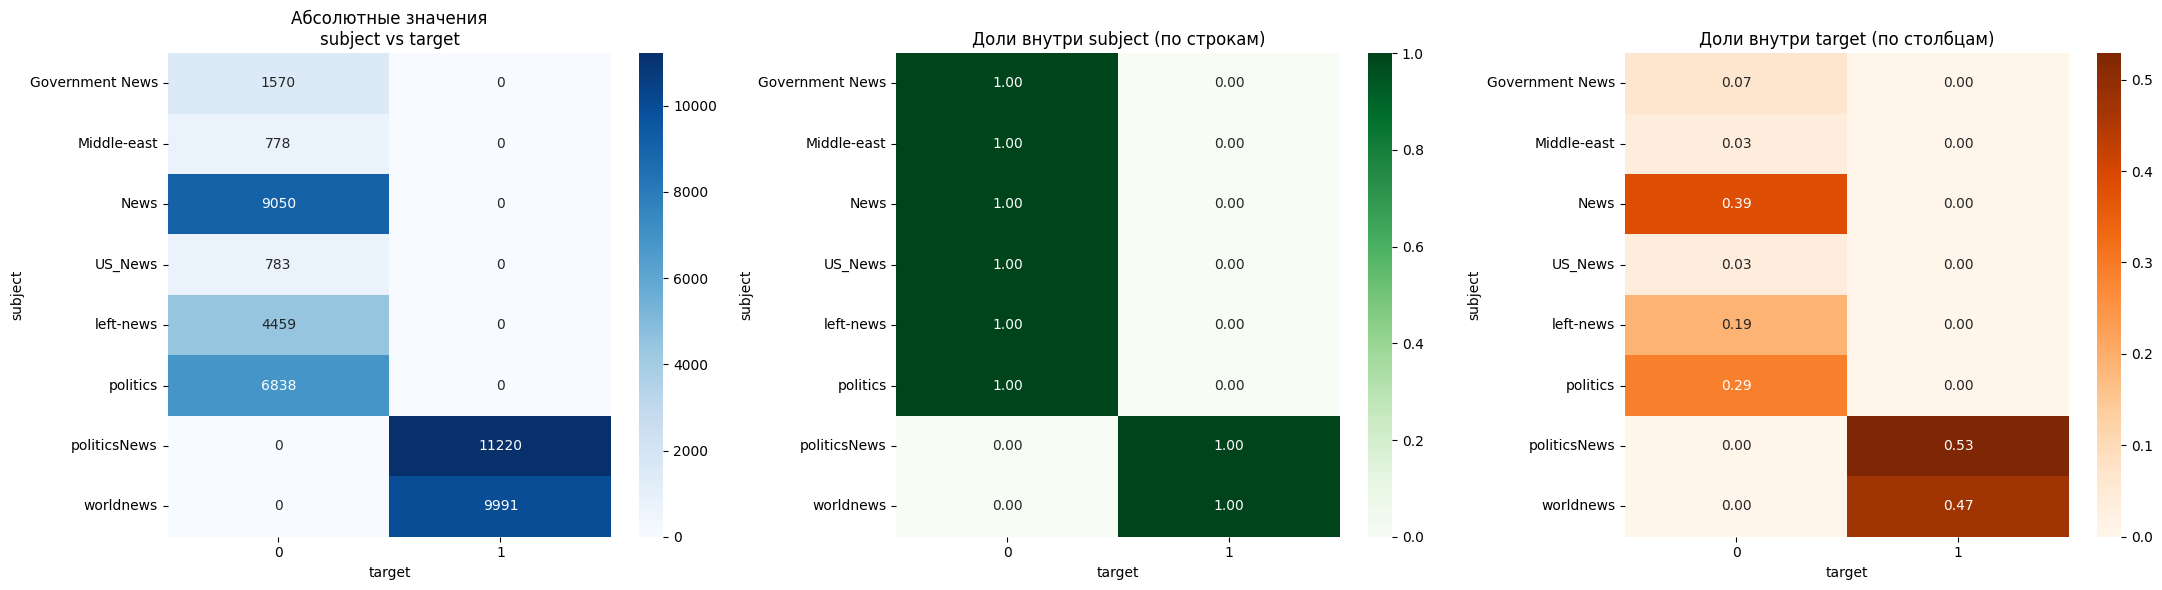

In [17]:
plot_categorical_relationship(df, 'subject', 'target')

крайне странное распределение, по какой то причине разные темы содержат только один таргет. при этом, это не ошибка склейки 2х датасетов. хотя, можно предположить что politics и politics_news, а так же news и world_news - одна категория по большому счету. в любом случае, исходя за такого распределения лучше всего избавиться от этой колонки позже

In [18]:
df['title_len'] = df['title'].fillna('').apply(lambda x: len(x.split()))

df['text_len'] = df['text'].fillna('').apply(lambda x: len(x.split()))

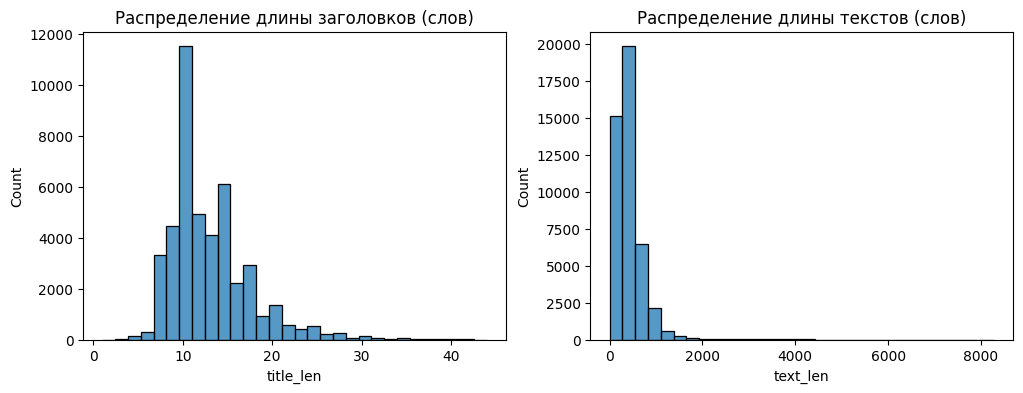

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['title_len'], bins=30, ax=axes[0])
axes[0].set_title('Распределение длины заголовков (слов)')
sns.histplot(df['text_len'], bins=30, ax=axes[1])
axes[1].set_title('Распределение длины текстов (слов)')
plt.show()

In [20]:
stop_words = stopwords.words('english')
vectorizer = CountVectorizer(max_features=30, stop_words=stop_words)
X = vectorizer.fit_transform(df['title'].fillna(''))

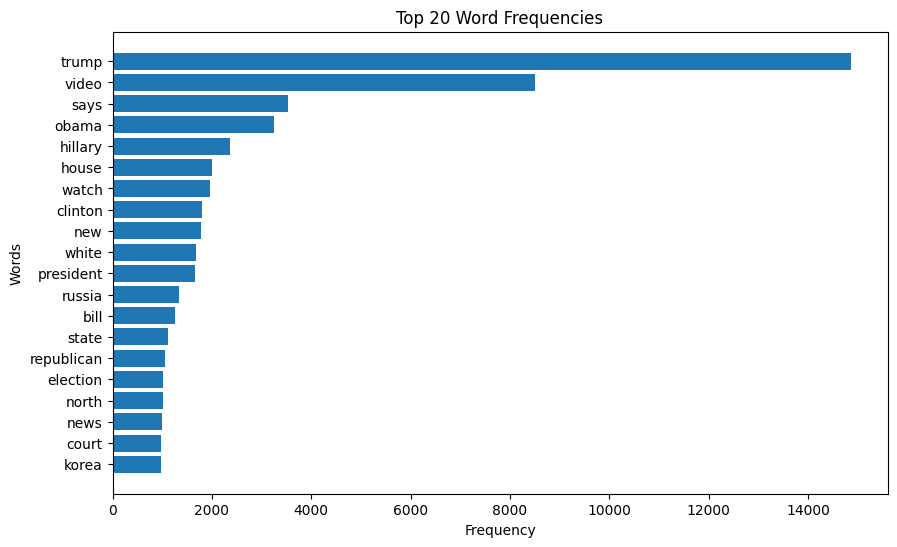

In [21]:
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

sorted_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]) # топ 20 самых популярных слов в заголовках

plt.figure(figsize=(10,6))
plt.barh(list(sorted_freq.keys())[::-1], list(sorted_freq.values())[::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Word Frequencies")
plt.show()

топ самых популярных слов в заголовках

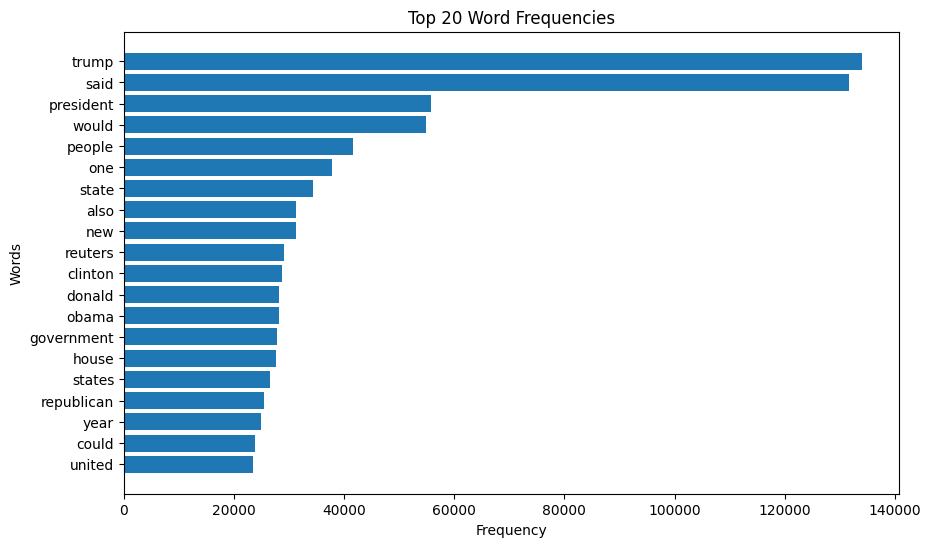

In [22]:
vectorizer = CountVectorizer(max_features=30, stop_words=stop_words) # сделаем тоже самое
X = vectorizer.fit_transform(df['text'].fillna(''))

word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

sorted_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]) # топ 20 самых популярных слов в текстах

plt.figure(figsize=(10,6))
plt.barh(list(sorted_freq.keys())[::-1], list(sorted_freq.values())[::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Word Frequencies")
plt.show()

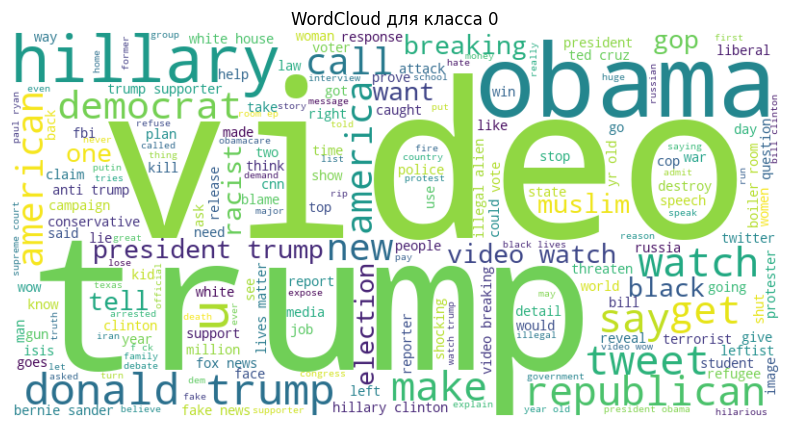

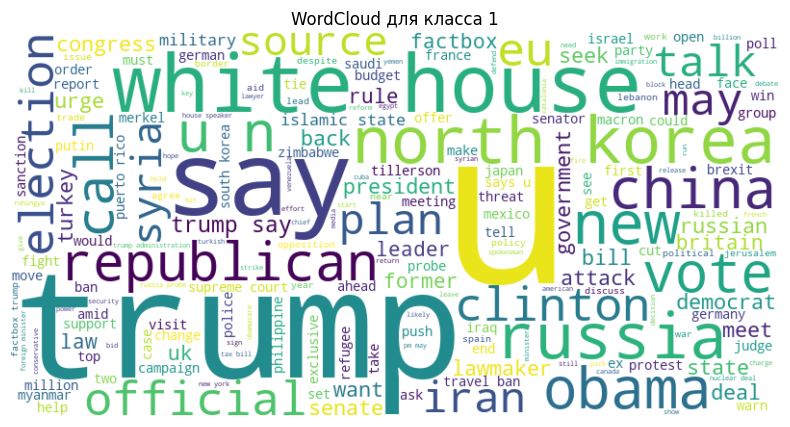

In [23]:
stop_words = set(stopwords.words('english'))


for cls in df['target'].unique():
    text_data = ' '.join(df[df['target'] == cls]['title'].fillna('').tolist())
    wc = WordCloud(width=800, height=400, stopwords=stop_words, background_color='white').generate(text_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud для класса {cls}')
    plt.show()

Весьма вероятно что в какой то момент времени модель столкнется с data drift, из за смены новостной повестки. поэтому, дата публикации новости бесполезна, и скорее, даже вредна. модель просто сопоставит временной промежуток и темы публикаций

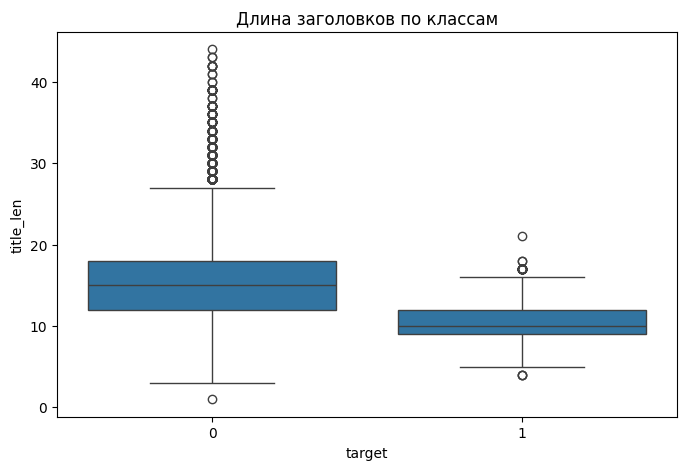

In [24]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='target', y='title_len', data=df)
plt.title('Длина заголовков по классам')
plt.show()

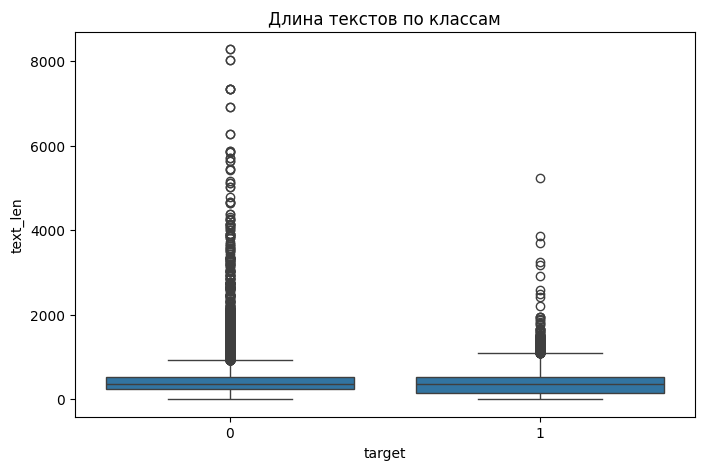

In [25]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='target', y='text_len', data=df)
plt.title('Длина текстов по классам')
plt.show()

можно заметить что в среднем правдивые новости короче

## CountVectorizer


In [26]:
SEED = 42

In [27]:
def split_dataset(path, target_value, date_col='date', target_col='target', ratio=0.8): # т.к. датасет лежит в 2 файлах и надо в тест взять самые новые новости приходится выкручиваться
    df = pd.read_csv(path)
    df[target_col] = target_value  # ставим таргет
    df = df.sort_values(date_col).reset_index(drop=True)
    split_idx = int(len(df) * ratio)

    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]

    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    X_test = test.drop(columns=[target_col])
    y_test = test[target_col]

    return X_train, X_test, y_train, y_test

# true = класс 1, false = класс 0
X_train_true, X_test_true, y_train_true, y_test_true = split_dataset('old/True.csv', target_value=1) # отдельно сплитим каждый датасет таким образом, что в тест попали самые свежие
X_train_false, X_test_false, y_train_false, y_test_false = split_dataset('old/Fake.csv', target_value=0)

# объединяем
X_train = pd.concat([X_train_true, X_train_false], ignore_index=True)
y_train = pd.concat([y_train_true, y_train_false], ignore_index=True)
X_test = pd.concat([X_test_true, X_test_false], ignore_index=True)
y_test = pd.concat([y_test_true, y_test_false], ignore_index=True)

# X_train['combo'] = X_train['title'] + X_train['text']
# X_test['combo'] = X_test['title'] + X_test['text']

cols_to_clean = ["title", "text"]

for df in [X_train, X_test]:
    for col in cols_to_clean:
        df[col] = df[col].apply(preprocessing)

# финальное распределение
print('Train distribution:\n', y_train.value_counts(normalize=True))
print('Test distribution:\n', y_test.value_counts(normalize=True))

Train distribution:
 target
0    0.522984
1    0.477016
Name: proportion, dtype: float64
Test distribution:
 target
0    0.522993
1    0.477007
Name: proportion, dtype: float64


In [28]:
stop_words = stopwords.words('english')
vectorizer = CountVectorizer(stop_words=stop_words, max_features=30)
X_train_text = vectorizer.fit_transform(X_train['text'].fillna(''))
X_test_text = vectorizer.fit_transform(X_test['text'].fillna(''))

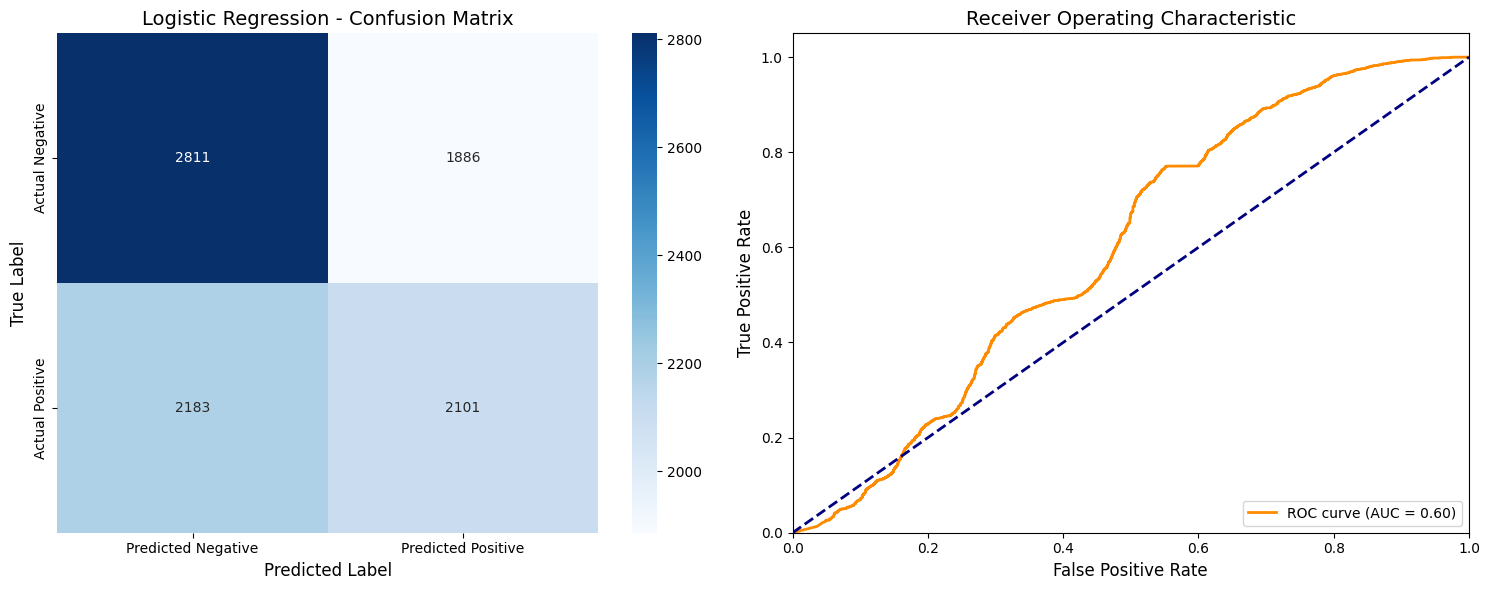


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.5971
Average Precision 0.5096
         F1 Score 0.5441
        Precision 0.5449
           Recall 0.5444
         Accuracy 0.5469


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.526963 0.490430
Negative   0.562875 0.598467



In [29]:
log_reg = LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')

log_reg.fit(X_train_text, y_train)

y_pred = log_reg.predict(X_test_text)
y_probs = log_reg.predict_proba(X_test_text)[:, 1]  

text_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

модель по тексту новости выше

In [30]:
X_train_title = vectorizer.fit_transform(X_train['title'].fillna(''))
X_test_title = vectorizer.fit_transform(X_test['title'].fillna(''))

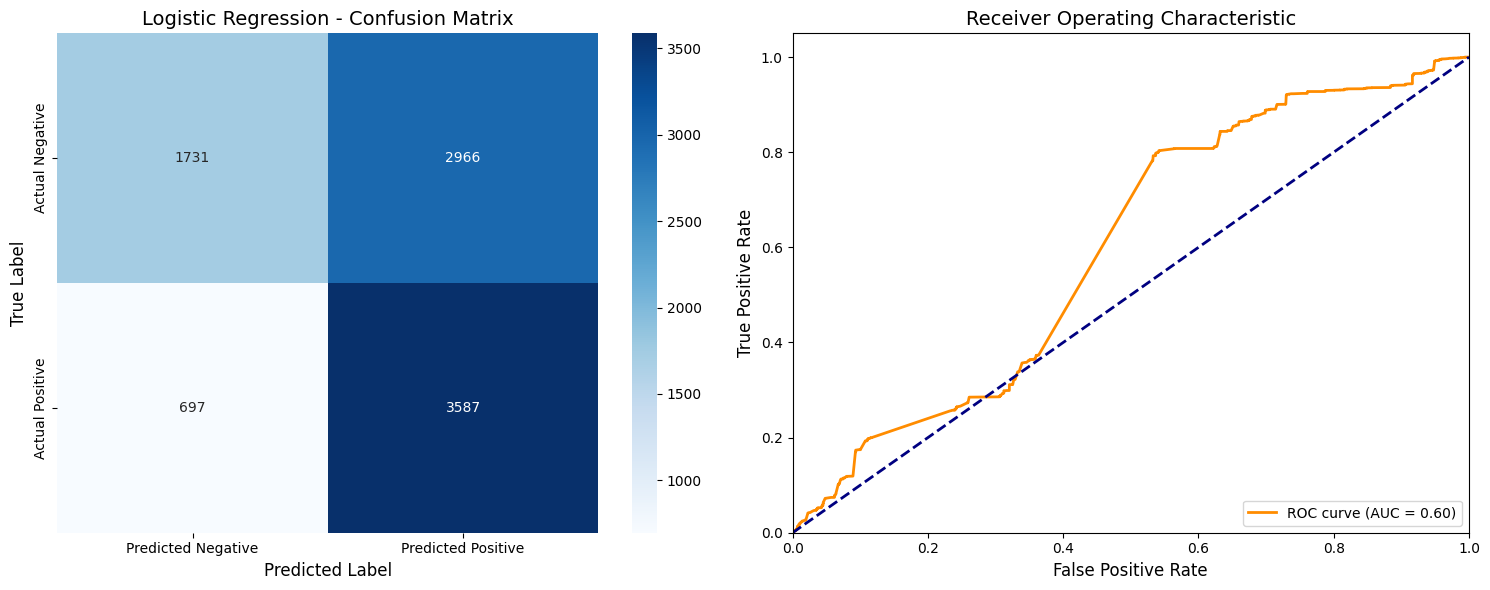


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.5965
Average Precision 0.5536
         F1 Score 0.5739
        Precision 0.6302
           Recall 0.6029
         Accuracy 0.5921


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.547383 0.837302
Negative   0.712932 0.368533



In [31]:
log_reg = LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')

log_reg.fit(X_train_title, y_train)

y_pred = log_reg.predict(X_test_title)
y_probs = log_reg.predict_proba(X_test_title)[:, 1]  

title_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

Модель построенная только от текста намного лучше той, что строится только от заголовка. далее буду строить модели только по заголовкам, т.к. модель по тексту уже дает почти идеальный результат

## TfidfVectorizer

In [33]:
X_train = X_train["title"]
X_test = X_test["title"]


X_train

0        trump sued in kentucky by three who say he inc...
1        in record year for political ads media buyers ...
2              obama republicans urge trump to soften tone
3        state department says halts review of clinton ...
4        obama trump doesn t know much about foreign po...
                               ...                        
35912    breaking leaked dhs memo tells of obama s plan...
35913    wikileaks red alert clinton camp exposed commi...
35914    breaking secret recordings about clinton found...
35915    black american on how i became a republican if...
35916    wow breaking news proof obama lied to press wa...
Name: title, Length: 35917, dtype: object

In [34]:
tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear'))
])

In [35]:
tfidf_pipe.fit(X_train, y_train)

y_pred = tfidf_pipe.predict(X_test)
y_probs = tfidf_pipe.predict_proba(X_test)[:, 1]  

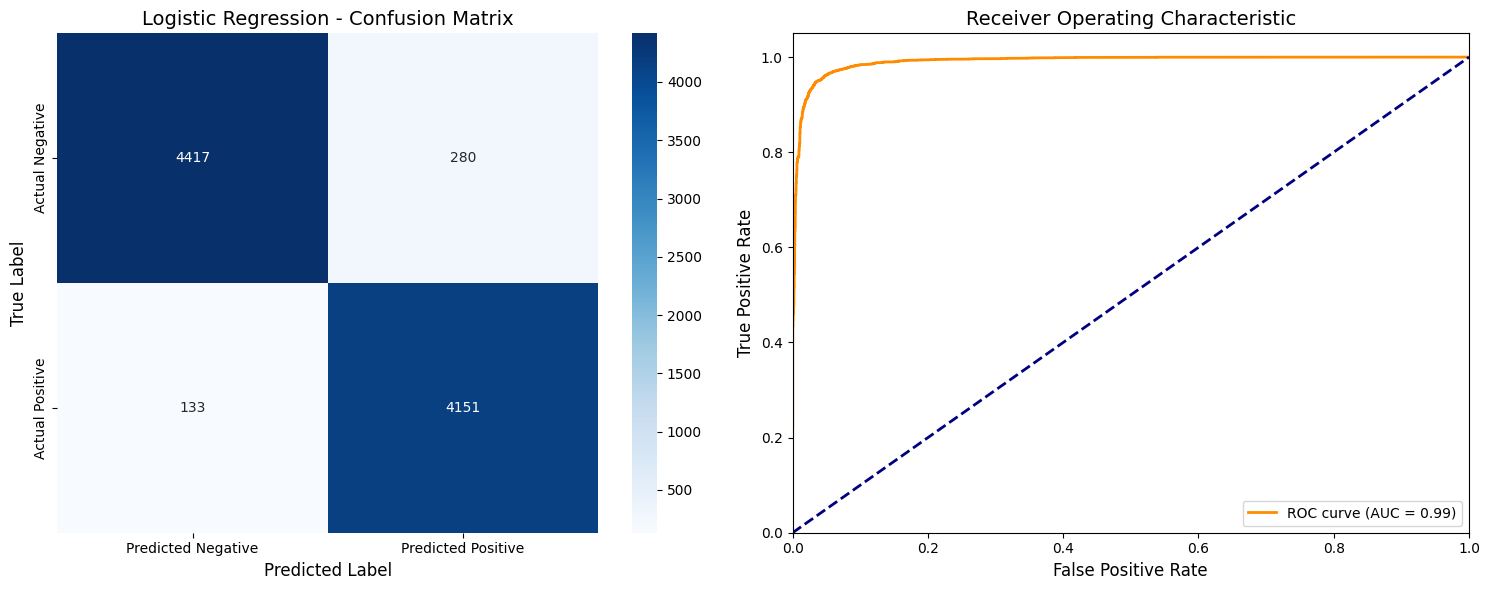


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9907
Average Precision 0.9896
         F1 Score 0.9540
        Precision 0.9538
           Recall 0.9547
         Accuracy 0.9540


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.936809 0.968954
Negative   0.970769 0.940387



In [36]:
tfidf_title_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

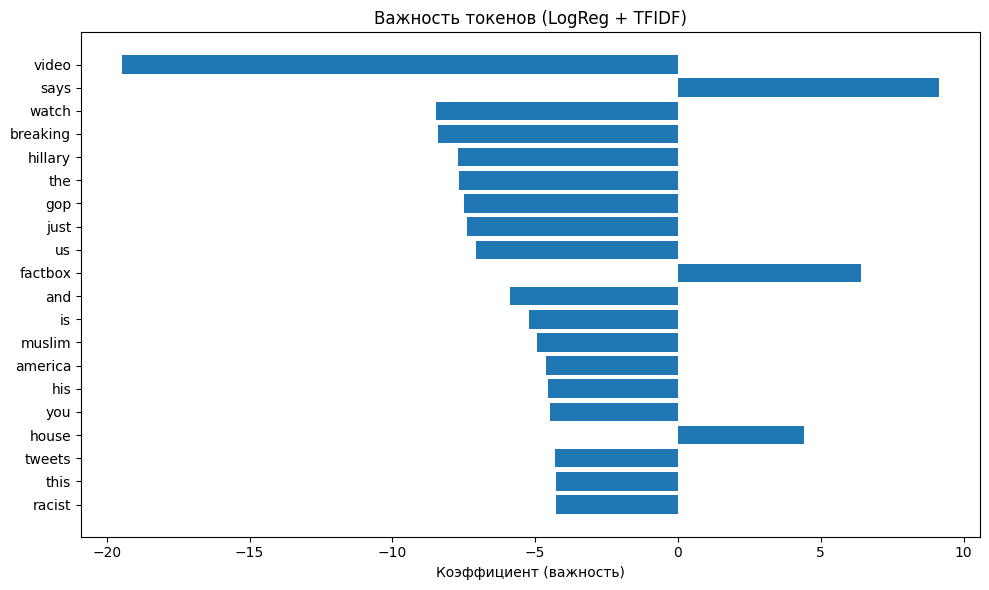

In [37]:
feature_names = tfidf_pipe.named_steps['tfidf'].get_feature_names_out()
coefs = tfidf_pipe.named_steps['logreg'].coef_[0]

token_importance = pd.DataFrame({
    'token': feature_names,
    'coef': coefs
})

top_tokens = token_importance.reindex(token_importance['coef'].abs().sort_values(ascending=False).index)[:20] # учитываем все токены, даже отрицательные

plt.figure(figsize=(10, 6))
plt.barh(top_tokens['token'], top_tokens['coef'])
plt.xlabel("Коэффициент (важность)")
plt.title("Важность токенов (LogReg + TFIDF)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

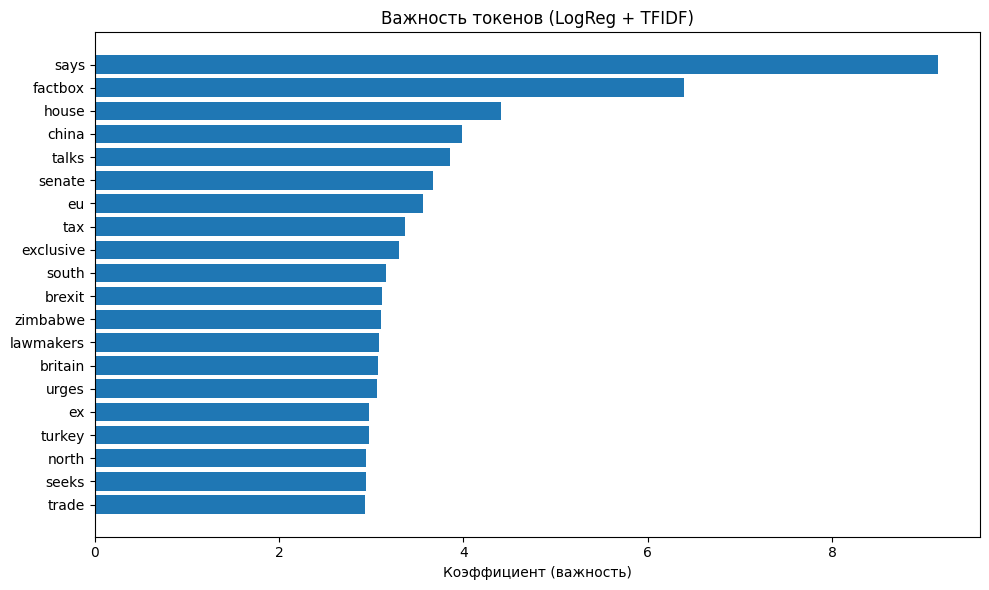

In [38]:
top_tokens = token_importance.reindex(token_importance['coef'].sort_values(ascending=False).index)[:20] # только положительные

plt.figure(figsize=(10, 6))
plt.barh(top_tokens['token'], top_tokens['coef'])
plt.xlabel("Коэффициент (важность)")
plt.title("Важность токенов (LogReg + TFIDF)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Намного лучше чем CountVectorizer

## HashingVectorizer

In [39]:
hashing_pipe = Pipeline([
    ('hashing', HashingVectorizer()),
    ('logreg', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear'))
])

In [40]:
hashing_pipe.fit(X_train, y_train)

y_pred = hashing_pipe.predict(X_test)
y_probs = hashing_pipe.predict_proba(X_test)[:, 1]  

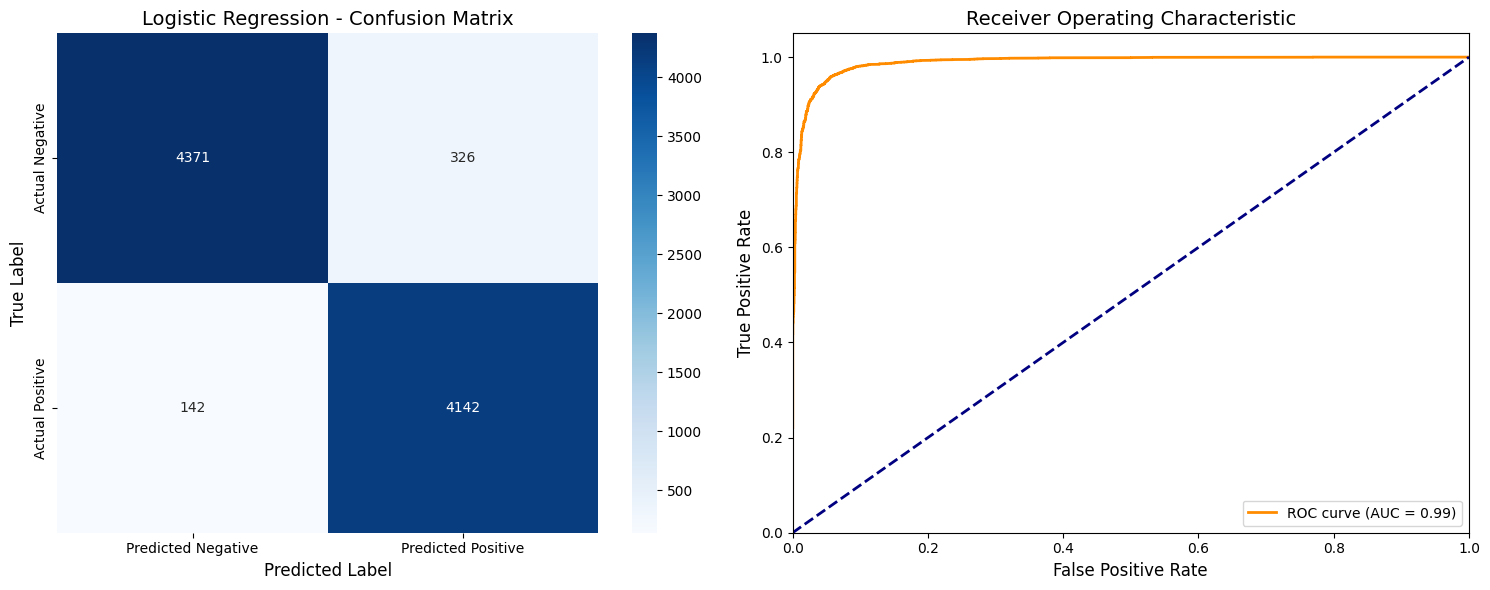


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9889
Average Precision 0.9876
         F1 Score 0.9479
        Precision 0.9478
           Recall 0.9487
         Accuracy 0.9479


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.927037 0.966853
Negative   0.968535 0.930594



In [41]:
hashing_title_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

примерно на том же уровне что и TFIDF

## Посмотрим как модели ведут себя без предобработки текста

Нет никакой предобработки: ни удаления знаков препинания, ни токенизации

In [42]:
df = pd.read_csv('dataset.csv', index_col=0)

In [43]:
X, y = divide_data(df, 'target')

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2, stratify=y)

In [45]:
X_train = X_train['title']
X_test = X_test['title']

X_train

37645    SocGen says no wrongdoing in handling of Natio...
30390    North Carolina governor concedes election to D...
18191    TRUMP FEVER! W. VA Dem Senator Says He Won’t V...
25384    New York vows to sue Trump over immigrant chil...
32622    Orlando killer expressed support for multiple ...
                               ...                        
9967     N KOREA JUST REVEALED Plans To Unleash An Unim...
26591    Trump to meet with top executives on wireless ...
8895      WATCH: Obama Goes BEAST MODE On CNN Anchor Fo...
18855    YIKES! Hillary Still Needs Help Walking On Sta...
41192    China's top paper warns party officials agains...
Name: title, Length: 35918, dtype: object

In [46]:
tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear'))
])

tfidf_pipe.fit(X_train, y_train)

y_pred = tfidf_pipe.predict(X_test)
y_probs = tfidf_pipe.predict_proba(X_test)[:, 1]  

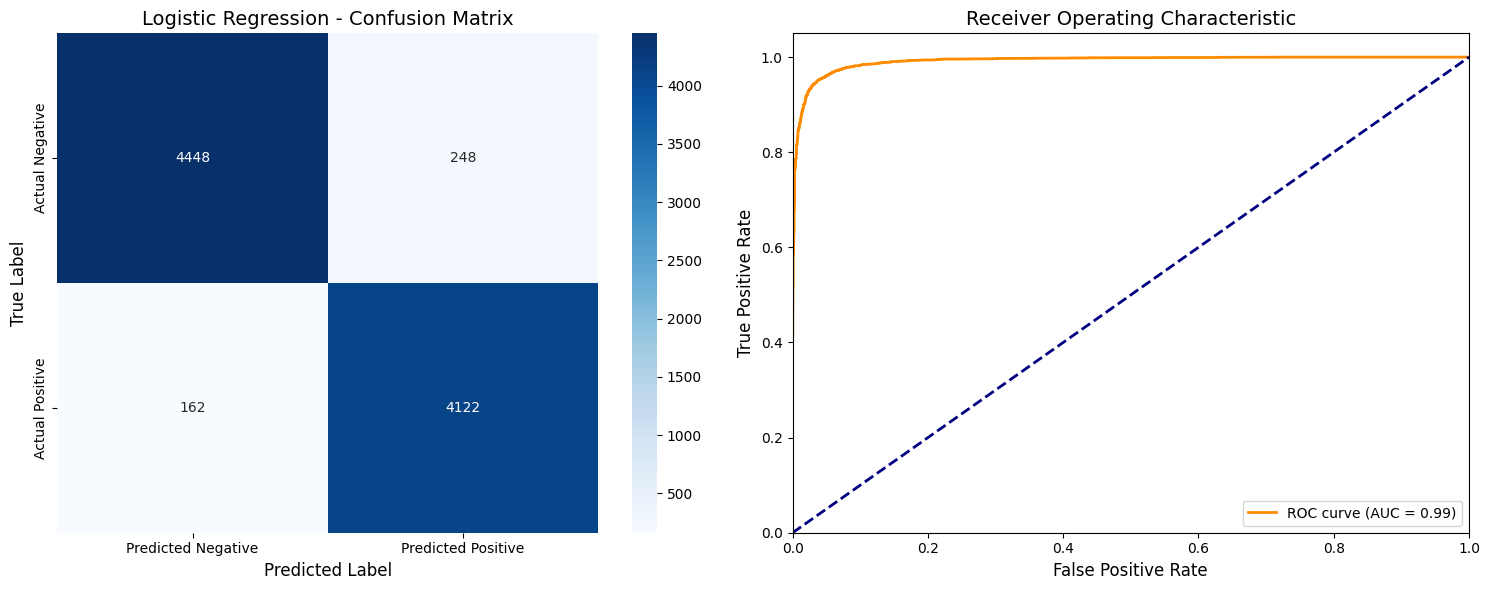


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9914
Average Precision 0.9911
         F1 Score 0.9543
        Precision 0.9541
           Recall 0.9547
         Accuracy 0.9543


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.943249 0.962185
Negative   0.964859 0.947189



In [47]:
tfidf_title_log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=False
)

Есть улучшение рок аука на 0.001%. по итогу, лучше удалить, прироста фактически нет

Построим диаграмму важности токенов

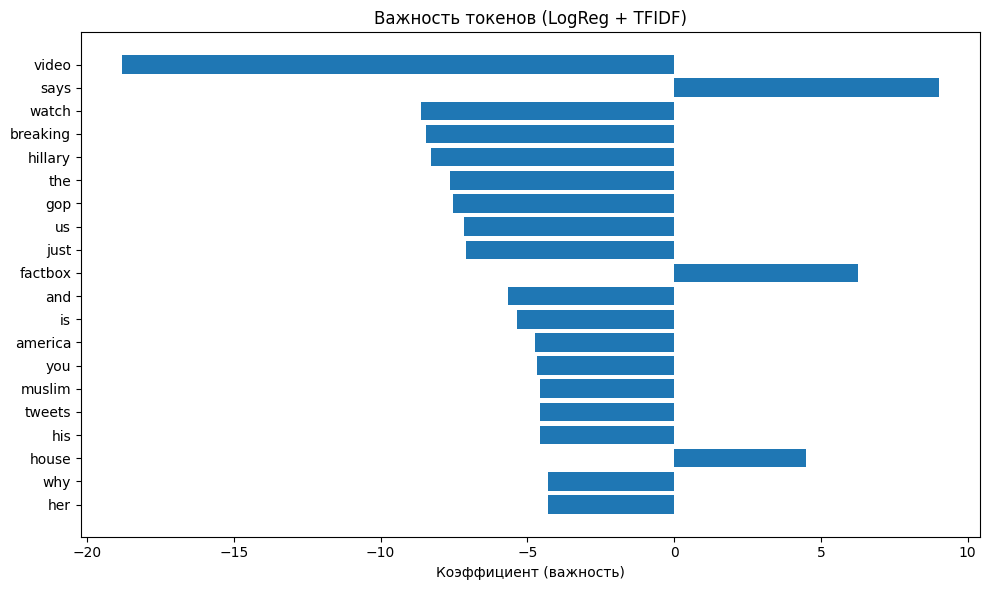

In [48]:
feature_names = tfidf_pipe.named_steps['tfidf'].get_feature_names_out()
coefs = tfidf_pipe.named_steps['logreg'].coef_[0]

token_importance = pd.DataFrame({
    'token': feature_names,
    'coef': coefs
})

top_tokens = token_importance.reindex(token_importance['coef'].abs().sort_values(ascending=False).index)[:20]

plt.figure(figsize=(10, 6))
plt.barh(top_tokens['token'], top_tokens['coef'])
plt.xlabel("Коэффициент (важность)")
plt.title("Важность токенов (LogReg + TFIDF)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()